In [1]:
import pandas as pd
import scirpy as ir
import Levenshtein
%matplotlib inline
import autoreload
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)

def calculate_v_mu_freq(df):
    df['distance_to_germline_v'] = df.apply(lambda x: Levenshtein.distance(x.v_sequence_alignment, x.v_germline_alignment), axis=1)
    df['v_mu_freq'] = df['distance_to_germline_v'] / df['v_sequence_alignment'].str.len()
    return df

## Prepare the data

In [4]:
# output of my snakemake
airr = pd.read_table('../../data/snakemake_outputs/combined_igblast.airr.tsv')

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### filter and munge

In [5]:
# get rid of merging artefacts
print("{} total assemblies out of snakemake".format(airr.shape[0]))
airr = airr.dropna(subset=['locus'])
print(airr.shape[0], "removed presumed merging artefacts")
airr = airr[airr.productive == "T"]
print(airr.shape[0], "removed unproductive chains")
airr = airr.dropna(subset=['locus'])

print("{} assemblies from TS".format(airr.shape[0]))

# reformatting 10X sequence id to merge with adata.obs
airr.loc[:,"cell_id"] = airr.sequence_id.replace('_contig_[0-9]', '', regex=True)
airr.cell_id.replace("\-","_", regex=True, inplace=True)
# 10X
airr.cell_id.replace("_5prime..CR", '_5prime', regex = True, inplace = True)
airr.cell_id.replace('_[0-9]_[T][S]', '_TS',regex = True, inplace = True)
airr.cell_id.replace('10X_[0-9]_[0-9]', '10X',regex = True, inplace = True)
airr.loc[:, 'cell_id'] = airr.cell_id.str.rsplit(" ", expand=True)[0]
airr.head().cell_id.values[-20:]
# Munge the data a little
airr.loc[:, 'cell_id'] = airr.cell_id.str.split('|', expand=True)[0]
airr = airr.dropna(subset=['junction'])
# scirpy needs umi_count column 
airr['umi_count'] = airr['umis']
airr['umi_count'].fillna(5, inplace=True)
airr['is_cell'] = True
airr['high_confidence'] = True
airr['multi_chain'] = False
# Want to assign c_calls to SS2 data in the snakemake, that's a todo
airr['c_call'] = 'None'
# rename column
airr = airr.rename({'cell_id_x':'cell_id'}, axis=1)

19252 total assemblies out of snakemake
19252 removed presumed merging artefacts
17780 removed unproductive chains
17780 assemblies from TS


In [6]:
# add a mutation frequency column
airr = calculate_v_mu_freq(airr)

# SCIRPY

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_type' as categorical
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_subtype' as categorical
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_c

single pair        5595
orphan VJ          2310
orphan VDJ         1737
extra VJ            453
ambiguous           168
extra VDJ            98
two full chains      47
multichain           18
Name: chain_pairing, dtype: int64


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [143757, 144258, 144244, 143761, 144159]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
100%|███████████████████████████████████████████████████| 4505/4505 [00:07<00:00, 631.66it/s]


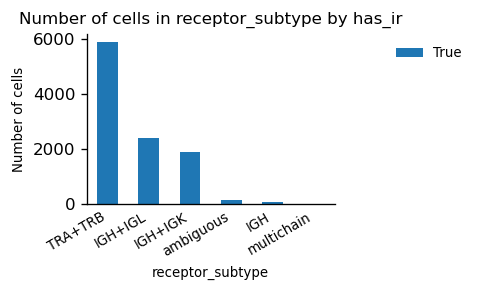

In [8]:
airr.to_csv('../../data/processed_data/airr_formatted.tsv', sep = '\t')

adata = ir.io.read_airr('../../data/processed_data/airr_formatted.tsv',include_fields=('productive', 'sequence', 'locus', 'v_call', 'd_call', 'j_call', 'c_call', 'junction', 'junction_aa', 'consensus_count', 'duplicate_count', 'v_mu_freq'))

ir.tl.chain_qc(adata)

print(adata.obs.chain_pairing.value_counts())
ax = ir.pl.group_abundance(adata, groupby='receptor_subtype')


# metadata from h5ad
met = pd.read_csv('../../metadata/TSP1_TSP15_metadata.csv')
met[(met.donor == "TSP1") & (met.method == 'smartseq2')].cell_id.str.rsplit(".", n = 5, expand = True)[0]
met['_cell_id'] = met['cell_id']
met['_cell_id'] = met['_cell_id'].str.replace('_[0-2]_[0-2]_5prime', '_5prime', regex = True)
met['_cell_id'] = met['_cell_id'].str.replace('.homo.gencode.v30.ERCC.chrM', '', regex = True)

merged = pd.merge(adata.obs, met, how = 'inner', left_on='cell_id', right_on='_cell_id')

adata = adata[adata.obs.index.isin(merged.cell_id)]

adata.obs = pd.merge(adata.obs, met, how = 'inner', left_index=True, right_on='cell_id')

adata.obs.index = adata.obs.cell_id

ir.pp.ir_dist(adata, metric="alignment", sequence='aa')

ir.tl.define_clonotypes(adata, key_added='clone_id')

# write the scirpy processed data out
adata.obs.to_csv('../../data/processed_data/merged_airr_scirpy.tsv', sep = '\t', index=False)